In [1]:
import pandas as pd

In [2]:
# getting the data file with reviews along with sentimental scores
df = pd.read_excel('sentimentalreviewdata.xlsx')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
filterdata = df[(df['len']>=20) & (df['len']<=150)]

In [5]:
filterdata = filterdata.sample(n=15000,random_state=101)

In [6]:
filterdata['reviewText'].to_csv('fakeData.csv')

In [7]:
# load reviews data into a Pandas DataFrame
df = pd.read_csv('fakeData.csv')
df.head()

,Unnamed: 0,reviewText
0,6332,"These really sounded nice for about 2.5 weeks,..."
1,39944,Good drive! Works great with no problems to s...
2,18169,"Nice camera, i bought when my d5200 was stolen..."
3,55427,This adaptor is a perfect fit for my Canon SX5...
4,42434,What a wonderful case! I have two ACER chromeb...


In [8]:
df = df.iloc[3255:3505]

In [9]:
df

,Unnamed: 0,reviewText
3255,94232,This is a nice aluminum bare hard drive case. ...
3256,70810,"Great hard disk drive for my laptop. Not slow,..."
3257,27960,Worked Fine in my testing. Didn't need a lot ...
3258,79709,"While they shipped their product on time, the ..."
3259,65981,It's amazing that this has totally replaced my...
...,...,...
3500,60826,A solid-feeling keyboard. There doesn't appear...
3501,39713,I like the high quality of workmanship this ba...
3502,25350,These Adapt-its are well thought out in that t...
3503,19604,Didn't help improve audio streaming as adverti...


## ChatGPT Detection



This section analyze each review if they are written by chatGPT or not.

In [17]:
saved_data = pd.DataFrame()

In [10]:
!pip install gptzero
from gptzero import GPTZeroAPI

In [11]:
# the api key to generate the predictions
api_key = '7dccb75991404b0380da4dadf334514b'
gptzero_api = GPTZeroAPI(api_key)

In [12]:
prob_data = df.copy(deep=True)

In [13]:
# sending the review text data (in batches of 250 instances per hour) to the api in order to predict probabilities
prob_data['ai_prob_score'] = df['reviewText'].apply(lambda x: gptzero_api.text_predict(x))

In [18]:
saved_data = saved_data.append(prob_data,ignore_index=True)

/var/folders/w7/r3sj_l0s11j7mjvdks7hxdzw0000gn/T/ipykernel_25797/1598923517.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  saved_data = saved_data.append(prob_data,ignore_index=True)


In [19]:
saved_data

,Unnamed: 0,reviewText,ai_prob_score
0,94232,This is a nice aluminum bare hard drive case. ...,{'error': 'API key has expired. If you have an...
1,70810,"Great hard disk drive for my laptop. Not slow,...",{'error': 'API key has expired. If you have an...
2,27960,Worked Fine in my testing. Didn't need a lot ...,{'error': 'API key has expired. If you have an...
3,79709,"While they shipped their product on time, the ...",{'error': 'API key has expired. If you have an...
4,65981,It's amazing that this has totally replaced my...,{'error': 'API key has expired. If you have an...
...,...,...,...
245,60826,A solid-feeling keyboard. There doesn't appear...,{'error': 'API key has expired. If you have an...
246,39713,I like the high quality of workmanship this ba...,{'error': 'API key has expired. If you have an...
247,25350,These Adapt-its are well thought out in that t...,{'error': 'API key has expired. If you have an...
248,19604,Didn't help improve audio streaming as adverti...,{'error': 'API key has expired. If you have an...


In [ ]:
# saved the first approx. 2000 rows in one excel
saved_data.to_excel('0.xlsx')

In [24]:
# saved the remaining rows in second excel (to prevent loss of data when api is unresponsive)
saved_data.to_excel('1.xlsx')

In [ ]:
r1 = pd.read_excel('O.xlsx')

In [ ]:
r2 = pd.read_excel('1.xlsx')

In [ ]:
r1 = r1.append(r2, ignore_index=True)

In [ ]:
r1 = r1.drop_duplicates()

In [ ]:
r1.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
# conversion of string generated from api into an object
r1['ai_prob_score'] = r1['ai_prob_score'].apply(eval)

In [ ]:
# extraction of probabilities from the 
r1['Prob']=r1['ai_prob_score'].apply(lambda x : x['documents'][0]['average_generated_prob'])

In [ ]:
fake_review = r1.merge(filterdata,how='inner',on='reviewText')

In [ ]:
# Categorizing the probabilities with less than or equal to 0.5 as FAKE
fake_review.iloc[fake_review['Prob']<=0.5,2] = 0

In [ ]:
# Categorizing the probabilities with greater than 0.5 as FAKE
fake_review.iloc[fake_review['Prob']>0.5,2] = 1

In [ ]:
# number of fake reviews
sum(fake_review['Prob']== 1)

In [ ]:
# number of non fake reviews
sum(fake_review['Prob']== 0)

In [ ]:
# saving the end results to an excel file
fake_review.to_excel('results.xlsx')

## Natural Language Processing



### Polarity Score of Review Summary


The code below is to **analyze the polarity** of each summary. We applied polarity in summary because polarity works best if sentence is short. As sentences get longer, more neutral words exist, and therefore, the overall score tends to normalize more towards neutral as well (or does it).

In [ ]:
nltk.download('vader_lexicon')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

df['summary'] = df['summary'].astype(str)
# apply sentiment analysis to each row in the dataset and store the results in a new column
df['sum_polarity_score'] = df['summary'].apply(lambda x: sia.polarity_scores(x)['compound'])

# print the updated dataset
df.head(5)

In [ ]:
pos_polarity_df = df[df["polarity_score"] > 0]
neg_polarity_df = df[df["polarity_score"] < 0]

In [ ]:
review_text1 = " ".join(review for review in pos_polarity_df.reviewText if isinstance(review, str))
#print(review_text1)
print(len(review_text1.split()))

5514497


### Sentiment Analysis of reviewText


The code below is to **analyze the sentiment** of each review text. We use a pre-trained language model in Spacy:

`spacy.load("en_core_web_sm")`

The model includes four emotion categories: anger, fear, joy, and sadness. 

In [ ]:
!pip install spacy
import spacy
!pip install text2emotion
import text2emotion as te



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=639f830606310e6d9e9eab323bf71c27485cfd279f11f430fc9a86f2cf6823e0
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
text = "I was asked to sign a third party contract a week out from stay. If it wasn't an 8 person group that took a lot of wrangling I would have cancelled the booking straight away. Bathrooms - there are no stand alone bathrooms. Please consider this - you have to clear out the main bedroom to use that bathroom. Other option is you walk through a different bedroom to get to its en-suite. Signs all over the apartment - there are signs everywhere - some helpful - some telling you rules. Perhaps some people like this but It negatively affected our enjoyment of the accommodation. Stairs - lots of them - some had slightly bending wood which caused a minor injury."

In [ ]:
nlp = spacy.load("en_core_web_sm")
# Define the emotion categories
categories = ["anger", "fear", "joy", "sadness"]

# Define some sample text
text = "I'm so happy to see you!"

# Process the text with Spacy
doc = nlp(text)

# Get the emotion scores for each category
emotion_scores = doc.cats

print(doc.cats)
# Print the emotion scores
#for category in categories:
    #print(f"{category}: {emotion_scores[category]}")

{}


## Word Cloud



In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

### Word Cloud for Overall Review

#### Word Cloud for Overall Review

In [ ]:
review_text = " ".join(review for review in df.reviewText if isinstance(review, str))

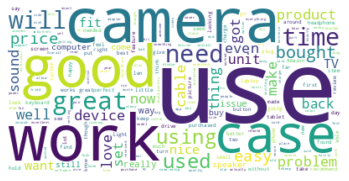

In [ ]:
# Create stopword list:
stopwords_review = set(STOPWORDS)
stopwords_review.update(["one"])

# Generate a word cloud image
wordcloud_text = WordCloud(stopwords=stopwords_review, background_color="white").generate(review_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
# wordcloud_text.to_file("wordcloud_text.png")

#### Word Cloud for Overall Review

In [ ]:
summary_text = " ".join(review for review in df.summary if isinstance(review, str))

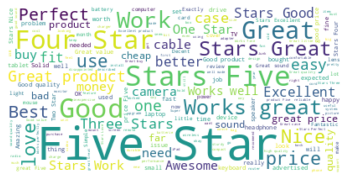

In [ ]:
# Create stopword list:
stopwords_summary = set(STOPWORDS)

# Generate a word cloud image
wordcloud_summary = WordCloud(stopwords=stopwords_summary, background_color="white").generate(summary_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
#wordcloud_summary.to_file("wordcloud_summary.png")

### Word Cloud for Positive Review

#### Word Cloud for Positive Review



In [ ]:
review_text = " ".join(review for review in pos_polarity_df.reviewText if isinstance(review, str))

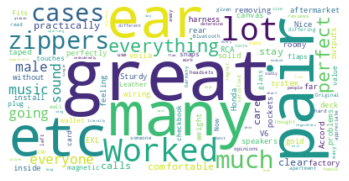

In [ ]:
# Create stopword list:
stopwords_review = set(STOPWORDS)
stopwords_review.update(["one"])

# Generate a word cloud image
wordcloud_text = WordCloud(stopwords=stopwords_review, background_color="white").generate(review_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
# wordcloud_text.to_file("wordcloud_text.png")

#### Word Cloud for Positive Review Summary

In [ ]:
summary_text = " ".join(review for review in pos_polarity_df.summary if isinstance(review, str))

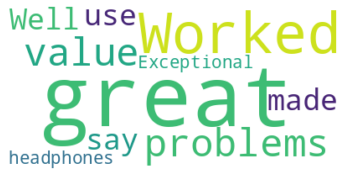

In [ ]:
# Create stopword list:
stopwords_summary = set(STOPWORDS)

# Generate a word cloud image
wordcloud_summary = WordCloud(stopwords=stopwords_summary, background_color="white").generate(summary_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
#wordcloud_summary.to_file("wordcloud_summary.png")

### Word Cloud for Negative Review

#### Word Cloud for Negative Review

In [ ]:
review_text = " ".join(review for review in neg_polarity_df.reviewText if isinstance(review, str))

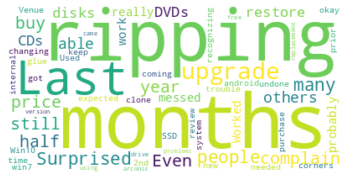

In [ ]:
# Create stopword list:
stopwords_review = set(STOPWORDS)
stopwords_review.update(["one"])

# Generate a word cloud image
wordcloud_text = WordCloud(stopwords=stopwords_review, background_color="white").generate(review_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
# wordcloud_text.to_file("wordcloud_text.png")

#### Word Cloud for Negative Review Summary


In [ ]:
summary_text = " ".join(review for review in neg_polarity_df.summary if isinstance(review, str))

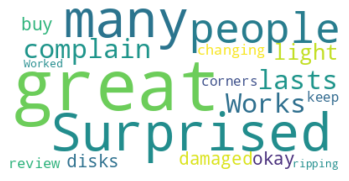

In [ ]:
# Create stopword list:
stopwords_summary = set(STOPWORDS)

# Generate a word cloud image
wordcloud_summary = WordCloud(stopwords=stopwords_summary, background_color="white").generate(summary_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.axis("off")
plt.show()

# Export to png
#wordcloud_summary.to_file("wordcloud_summary.png")